In [1]:
from models.transformers import DecoderOnlyTransformer
import torch
from torch.utils.data import DataLoader
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import shutil
import wandb
import yaml
from data.datasets import CFGDataset, verify_dataloader
from trainers.GPT_trainer import GPT_Trainer
from trainers.utils import create_optimizer, create_scheduler
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#Read config yaml file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
print(f"Config loaded successfully.")


import os
os.system("export WANDB_DIR=\tmp")
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


Using device: cuda
Config loaded successfully.


0

#### Loading Data

In [2]:
train_dataset =  CFGDataset(
    data_file="cfg_sentences_val_cfg3b_samelen.npy", 
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    )

val_dataset =  CFGDataset(
    data_file="cfg_sentences_val_cfg3b_samelen.npy", 
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 


train_loader = DataLoader(train_dataset, 
                          batch_size = config["data"]["batch_size"], 
                          num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0, 
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=config["data"]["batch_size"], 
                        num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0,
                        pin_memory=True)

verify_dataloader(train_loader)
print("_"*50)
verify_dataloader(val_loader)
#print("="*50)
#print("Verify Validation DataLoader")
#verify_dataloader(val_loader)

Verifying dataloader...
Number of batches:  63
Total number of tokens:  2.608000e+06


Example batch shapes (shifted, golden):  torch.Size([128, 325]) torch.Size([128, 325])
__________________________________________________
Verifying dataloader...
Number of batches:  63
Total number of tokens:  2.608000e+06
Example batch shapes (shifted, golden):  torch.Size([128, 325]) torch.Size([128, 325])


In [3]:
model_config = {}
model_config = config['model'].copy()

model_config.update({
    'num_classes': config["data"]["vocab_size"] +2 ,#include SOS and EOS tolen
    'seq_len': config["data"]["seq_len"],
    })

model = DecoderOnlyTransformer(**model_config)

for batch in val_loader:
    shifted_transcripts, golden_transcripts = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    break
model.to(device)
shifted_transcripts = shifted_transcripts.to(device)
model_stats = summary(model, input_data=[shifted_transcripts])
print(model_stats)
#print(f"Total parameters in the model: {sum(p.numel() for p in model.parameters()):,}")
#torch._dynamo.config.skip_nnmodule_hook_guards = False
#model = torch.compile(model, mode="default", fullgraph=True)


Shape of shifted_transcripts :  torch.Size([128, 325])
Shape of golden_transcripts  :  torch.Size([128, 325])
Layer (type:depth-idx)                        Output Shape              Param #
DecoderOnlyTransformer                        [128, 325, 5]             --
├─Embedding: 1-1                              [128, 325, 768]           3,840
├─Dropout: 1-2                                [128, 325, 768]           --
├─ModuleList: 1-3                             --                        --
│    └─SelfAttentionDecoderLayer: 2-1         [128, 325, 768]           --
│    │    └─SelfAttentionLayer: 3-1           --                        2,363,904
│    │    └─FeedForwardLayer: 3-2             [128, 325, 768]           4,723,968
│    └─SelfAttentionDecoderLayer: 2-2         [128, 325, 768]           --
│    │    └─SelfAttentionLayer: 3-3           --                        2,363,904
│    │    └─FeedForwardLayer: 3-4             [128, 325, 768]           4,723,968
│    └─SelfAttentionDecoderLa

In [4]:

torch.cuda.empty_cache()
gc.collect()
#wandb.finish()
#wandb.login("11902c0c8e2c6840d72bf65f04894b432d85f019")

trainer = GPT_Trainer(
    model = model, 
    config = config,
    config_file = "config.yaml",
    run_name = "run", 
    device = device
)
#wandb.watch(trainer.model, log="all")

trainer.optimizer = create_optimizer.create_optimizer(
    model = model, 
    opt_config = config["optimizer"]
)

trainer.scheduler = create_scheduler.create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)
trainer.load_checkpoint("checkpoint-best-metric-model.pth")
#plot_lr_schedule(trainer.scheduler, num_epochs=len(train_loader), train_loader=train_loader)

#trainer.load_checkpoint("th")

Using device: cuda

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0003
├── Weight Decay: 0.01
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0003
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0003
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.98]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 63 steps
│   └── Min LR: 1e-08
└── Warmup: Disabled
Checkpoint loaded from batch 57000
Successfully loaded: model, optimizer, scheduler, scaler, training_state


In [5]:
import math
math.exp(trainer.best_metric)

1.3860049126834286

In [6]:
trainer.model.train()

#trainer._validate_epoch(val_loader)
trainer.train_epoch(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)

generating
Using default generation config...
Generating with greedy search...


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


wandb metrics being logged:  {'train/ce_loss_token': 0.8428010650261671, 'train/perplexity_token': 2.322864532470703, 'val/ce_loss_token': 0.40504008531570435, 'val/perplexity_token': 1.499362587928772, 'learning_rate': 0.0003999364605611181}

📊 Metrics (Epoch 500):
├── TRAIN:
│   ├── ce_loss_token: 0.8428
│   └── perplexity_token: 2.3229
└── VAL:
    ├── ce_loss_token: 0.4050
    └── perplexity_token: 1.4994
└── TRAINING:
    └── learning_rate: 0.000400


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.6088825992711416, 'train/perplexity_token': 1.8383760452270508, 'val/ce_loss_token': 0.33808494359254837, 'val/perplexity_token': 1.4022595882415771, 'learning_rate': 0.00039974638947813115}

📊 Metrics (Epoch 1000):
├── TRAIN:
│   ├── ce_loss_token: 0.6089
│   └── perplexity_token: 1.8384
└── VAL:
    ├── ce_loss_token: 0.3381
    └── perplexity_token: 1.4023
└── TRAINING:
    └── learning_rate: 0.000400


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.5203972211644937, 'train/perplexity_token': 1.682695984840393, 'val/ce_loss_token': 0.33241614513099194, 'val/perplexity_token': 1.394333004951477, 'learning_rate': 0.0003994299067893801}

📊 Metrics (Epoch 1500):
├── TRAIN:
│   ├── ce_loss_token: 0.5204
│   └── perplexity_token: 1.6827
└── VAL:
    ├── ce_loss_token: 0.3324
    └── perplexity_token: 1.3943
└── TRAINING:
    └── learning_rate: 0.000399


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.4744930782209689, 'train/perplexity_token': 1.6071993112564087, 'val/ce_loss_token': 0.33062182646244764, 'val/perplexity_token': 1.3918333053588867, 'learning_rate': 0.0003989872127892792}

📊 Metrics (Epoch 2000):
├── TRAIN:
│   ├── ce_loss_token: 0.4745
│   └── perplexity_token: 1.6072
└── VAL:
    ├── ce_loss_token: 0.3306
    └── perplexity_token: 1.3918
└── TRAINING:
    └── learning_rate: 0.000399


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.4460213576398435, 'train/perplexity_token': 1.5620847940444946, 'val/ce_loss_token': 0.3291814811527729, 'val/perplexity_token': 1.3898301124572754, 'learning_rate': 0.0003984185876484016}

📊 Metrics (Epoch 2500):
├── TRAIN:
│   ├── ce_loss_token: 0.4460
│   └── perplexity_token: 1.5621
└── VAL:
    ├── ce_loss_token: 0.3292
    └── perplexity_token: 1.3898
└── TRAINING:
    └── learning_rate: 0.000398


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.42677976457685757, 'train/perplexity_token': 1.5323151350021362, 'val/ce_loss_token': 0.32753420900553465, 'val/perplexity_token': 1.387542486190796, 'learning_rate': 0.00039772439123616284}

📊 Metrics (Epoch 3000):
├── TRAIN:
│   ├── ce_loss_token: 0.4268
│   └── perplexity_token: 1.5323
└── VAL:
    ├── ce_loss_token: 0.3275
    └── perplexity_token: 1.3875
└── TRAINING:
    └── learning_rate: 0.000398


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.412863311470321, 'train/perplexity_token': 1.5111384391784668, 'val/ce_loss_token': 0.3274521194398403, 'val/perplexity_token': 1.387428641319275, 'learning_rate': 0.0003969050628930687}

📊 Metrics (Epoch 3500):
├── TRAIN:
│   ├── ce_loss_token: 0.4129
│   └── perplexity_token: 1.5111
└── VAL:
    ├── ce_loss_token: 0.3275
    └── perplexity_token: 1.3874
└── TRAINING:
    └── learning_rate: 0.000397


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.40228259515029374, 'train/perplexity_token': 1.4952337741851807, 'val/ce_loss_token': 0.3268726449459791, 'val/perplexity_token': 1.3866249322891235, 'learning_rate': 0.000395961121152669}

📊 Metrics (Epoch 4000):
├── TRAIN:
│   ├── ce_loss_token: 0.4023
│   └── perplexity_token: 1.4952
└── VAL:
    ├── ce_loss_token: 0.3269
    └── perplexity_token: 1.3866
└── TRAINING:
    └── learning_rate: 0.000396


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.39396360835031097, 'train/perplexity_token': 1.4828466176986694, 'val/ce_loss_token': 0.32678673323243856, 'val/perplexity_token': 1.3865057229995728, 'learning_rate': 0.0003948931634133863}

📊 Metrics (Epoch 4500):
├── TRAIN:
│   ├── ce_loss_token: 0.3940
│   └── perplexity_token: 1.4828
└── VAL:
    ├── ce_loss_token: 0.3268
    └── perplexity_token: 1.3865
└── TRAINING:
    └── learning_rate: 0.000395


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.38729183940476497, 'train/perplexity_token': 1.4729863405227661, 'val/ce_loss_token': 0.32654218282550573, 'val/perplexity_token': 1.3861666917800903, 'learning_rate': 0.00039370186556043945}

📊 Metrics (Epoch 5000):
├── TRAIN:
│   ├── ce_loss_token: 0.3873
│   └── perplexity_token: 1.4730
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3862
└── TRAINING:
    └── learning_rate: 0.000394


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.38182219887858976, 'train/perplexity_token': 1.4649516344070435, 'val/ce_loss_token': 0.3266288749873638, 'val/perplexity_token': 1.3862868547439575, 'learning_rate': 0.0003923879815380904}

📊 Metrics (Epoch 5500):
├── TRAIN:
│   ├── ce_loss_token: 0.3818
│   └── perplexity_token: 1.4650
└── VAL:
    ├── ce_loss_token: 0.3266
    └── perplexity_token: 1.3863
└── TRAINING:
    └── learning_rate: 0.000392


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3772583322422919, 'train/perplexity_token': 1.4582810401916504, 'val/ce_loss_token': 0.32700235303491354, 'val/perplexity_token': 1.3868046998977661, 'learning_rate': 0.00039095234287249214}

📊 Metrics (Epoch 6000):
├── TRAIN:
│   ├── ce_loss_token: 0.3773
│   └── perplexity_token: 1.4583
└── VAL:
    ├── ce_loss_token: 0.3270
    └── perplexity_token: 1.3868
└── TRAINING:
    └── learning_rate: 0.000391


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.37338559489271456, 'train/perplexity_token': 1.4526443481445312, 'val/ce_loss_token': 0.3268392877653241, 'val/perplexity_token': 1.3865786790847778, 'learning_rate': 0.0003893958581454336}

📊 Metrics (Epoch 6500):
├── TRAIN:
│   ├── ce_loss_token: 0.3734
│   └── perplexity_token: 1.4526
└── VAL:
    ├── ce_loss_token: 0.3268
    └── perplexity_token: 1.3866
└── TRAINING:
    └── learning_rate: 0.000389


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.37006412633162467, 'train/perplexity_token': 1.4478274583816528, 'val/ce_loss_token': 0.32651410065591335, 'val/perplexity_token': 1.3861278295516968, 'learning_rate': 0.00038771951241931994}

📊 Metrics (Epoch 7000):
├── TRAIN:
│   ├── ce_loss_token: 0.3701
│   └── perplexity_token: 1.4478
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3861
└── TRAINING:
    └── learning_rate: 0.000388


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3671817093583015, 'train/perplexity_token': 1.4436602592468262, 'val/ce_loss_token': 0.32672066427767277, 'val/perplexity_token': 1.3864141702651978, 'learning_rate': 0.00038592436661375146}

📊 Metrics (Epoch 7500):
├── TRAIN:
│   ├── ce_loss_token: 0.3672
│   └── perplexity_token: 1.4437
└── VAL:
    ├── ce_loss_token: 0.3267
    └── perplexity_token: 1.3864
└── TRAINING:
    └── learning_rate: 0.000386


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3646590045699029, 'train/perplexity_token': 1.4400229454040527, 'val/ce_loss_token': 0.32644047960639, 'val/perplexity_token': 1.3860257863998413, 'learning_rate': 0.0003840115568340933}

📊 Metrics (Epoch 8000):
├── TRAIN:
│   ├── ce_loss_token: 0.3647
│   └── perplexity_token: 1.4400
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000384


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.36243071617161354, 'train/perplexity_token': 1.4368176460266113, 'val/ce_loss_token': 0.3264729483053088, 'val/perplexity_token': 1.386070728302002, 'learning_rate': 0.00038198229365245554}

📊 Metrics (Epoch 8500):
├── TRAIN:
│   ├── ce_loss_token: 0.3624
│   └── perplexity_token: 1.4368
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3861
└── TRAINING:
    └── learning_rate: 0.000382


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3604488431043247, 'train/perplexity_token': 1.4339728355407715, 'val/ce_loss_token': 0.3266940424218774, 'val/perplexity_token': 1.386377215385437, 'learning_rate': 0.00037983786134155787}

📊 Metrics (Epoch 9000):
├── TRAIN:
│   ├── ce_loss_token: 0.3604
│   └── perplexity_token: 1.4340
└── VAL:
    ├── ce_loss_token: 0.3267
    └── perplexity_token: 1.3864
└── TRAINING:
    └── learning_rate: 0.000380


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.35867664063934174, 'train/perplexity_token': 1.431433916091919, 'val/ce_loss_token': 0.3265836872160435, 'val/perplexity_token': 1.3862242698669434, 'learning_rate': 0.0003775796170619394}

📊 Metrics (Epoch 9500):
├── TRAIN:
│   ├── ce_loss_token: 0.3587
│   └── perplexity_token: 1.4314
└── VAL:
    ├── ce_loss_token: 0.3266
    └── perplexity_token: 1.3862
└── TRAINING:
    └── learning_rate: 0.000378


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3570804307221437, 'train/perplexity_token': 1.4291508197784424, 'val/ce_loss_token': 0.32648816984146833, 'val/perplexity_token': 1.3860918283462524, 'learning_rate': 0.0003752089900030455}

📊 Metrics (Epoch 10000):
├── TRAIN:
│   ├── ce_loss_token: 0.3571
│   └── perplexity_token: 1.4292
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3861
└── TRAINING:
    └── learning_rate: 0.000375


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.35563562629779355, 'train/perplexity_token': 1.427087426185608, 'val/ce_loss_token': 0.3265391355380416, 'val/perplexity_token': 1.386162519454956, 'learning_rate': 0.0003727274804787263}

📊 Metrics (Epoch 10500):
├── TRAIN:
│   ├── ce_loss_token: 0.3556
│   └── perplexity_token: 1.4271
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3862
└── TRAINING:
    └── learning_rate: 0.000373


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3543211369040489, 'train/perplexity_token': 1.4252127408981323, 'val/ce_loss_token': 0.3265414768829942, 'val/perplexity_token': 1.386165738105774, 'learning_rate': 0.00037013665897772625}

📊 Metrics (Epoch 11000):
├── TRAIN:
│   ├── ce_loss_token: 0.3543
│   └── perplexity_token: 1.4252
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3862
└── TRAINING:
    └── learning_rate: 0.000370


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.35312069995891904, 'train/perplexity_token': 1.4235029220581055, 'val/ce_loss_token': 0.3263593418523669, 'val/perplexity_token': 1.3859132528305054, 'learning_rate': 0.00036743816516975476}

📊 Metrics (Epoch 11500):
├── TRAIN:
│   ├── ce_loss_token: 0.3531
│   └── perplexity_token: 1.4235
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3859
└── TRAINING:
    └── learning_rate: 0.000367


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.35201987645276617, 'train/perplexity_token': 1.4219367504119873, 'val/ce_loss_token': 0.32643328979611397, 'val/perplexity_token': 1.386015772819519, 'learning_rate': 0.0003646337068677798}

📊 Metrics (Epoch 12000):
├── TRAIN:
│   ├── ce_loss_token: 0.3520
│   └── perplexity_token: 1.4219
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000365


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3510054797422847, 'train/perplexity_token': 1.4204951524734497, 'val/ce_loss_token': 0.32665344327688217, 'val/perplexity_token': 1.386320948600769, 'learning_rate': 0.00036172505894719616}

📊 Metrics (Epoch 12500):
├── TRAIN:
│   ├── ce_loss_token: 0.3510
│   └── perplexity_token: 1.4205
└── VAL:
    ├── ce_loss_token: 0.3267
    └── perplexity_token: 1.3863
└── TRAINING:
    └── learning_rate: 0.000362


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.35006939443099794, 'train/perplexity_token': 1.419166088104248, 'val/ce_loss_token': 0.3264287179335952, 'val/perplexity_token': 1.3860094547271729, 'learning_rate': 0.0003587140622225435}

📊 Metrics (Epoch 13000):
├── TRAIN:
│   ├── ce_loss_token: 0.3501
│   └── perplexity_token: 1.4192
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000359


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.34920374280823113, 'train/perplexity_token': 1.417937994003296, 'val/ce_loss_token': 0.3264961428940296, 'val/perplexity_token': 1.3861029148101807, 'learning_rate': 0.0003556026222825048}

📊 Metrics (Epoch 13500):
├── TRAIN:
│   ├── ce_loss_token: 0.3492
│   └── perplexity_token: 1.4179
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3861
└── TRAINING:
    └── learning_rate: 0.000356


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.348400042068702, 'train/perplexity_token': 1.4167989492416382, 'val/ce_loss_token': 0.3265754207968712, 'val/perplexity_token': 1.3862128257751465, 'learning_rate': 0.0003523927082838975}

📊 Metrics (Epoch 14000):
├── TRAIN:
│   ├── ce_loss_token: 0.3484
│   └── perplexity_token: 1.4168
└── VAL:
    ├── ce_loss_token: 0.3266
    └── perplexity_token: 1.3862
└── TRAINING:
    └── learning_rate: 0.000352


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.34765167829579513, 'train/perplexity_token': 1.4157390594482422, 'val/ce_loss_token': 0.32638152688741684, 'val/perplexity_token': 1.3859440088272095, 'learning_rate': 0.0003490863517054464}

📊 Metrics (Epoch 14500):
├── TRAIN:
│   ├── ce_loss_token: 0.3477
│   └── perplexity_token: 1.4157
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3859
└── TRAINING:
    └── learning_rate: 0.000349


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3469528990915224, 'train/perplexity_token': 1.414750099182129, 'val/ce_loss_token': 0.3264241013675928, 'val/perplexity_token': 1.386003017425537, 'learning_rate': 0.0003456856450621038}

📊 Metrics (Epoch 15000):
├── TRAIN:
│   ├── ce_loss_token: 0.3470
│   └── perplexity_token: 1.4148
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000346


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.34630017736697766, 'train/perplexity_token': 1.4138269424438477, 'val/ce_loss_token': 0.3267107056453824, 'val/perplexity_token': 1.3864003419876099, 'learning_rate': 0.0003421927405807504}

📊 Metrics (Epoch 15500):
├── TRAIN:
│   ├── ce_loss_token: 0.3463
│   └── perplexity_token: 1.4138
└── VAL:
    ├── ce_loss_token: 0.3267
    └── perplexity_token: 1.3864
└── TRAINING:
    └── learning_rate: 0.000342


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3456879749900661, 'train/perplexity_token': 1.412961721420288, 'val/ce_loss_token': 0.32669500447809696, 'val/perplexity_token': 1.386378526687622, 'learning_rate': 0.00033860984883809977}

📊 Metrics (Epoch 16000):
├── TRAIN:
│   ├── ce_loss_token: 0.3457
│   └── perplexity_token: 1.4130
└── VAL:
    ├── ce_loss_token: 0.3267
    └── perplexity_token: 1.3864
└── TRAINING:
    └── learning_rate: 0.000339


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.34511214121566613, 'train/perplexity_token': 1.4121482372283936, 'val/ce_loss_token': 0.32638959866017103, 'val/perplexity_token': 1.3859552145004272, 'learning_rate': 0.0003349392373616758}

📊 Metrics (Epoch 16500):
├── TRAIN:
│   ├── ce_loss_token: 0.3451
│   └── perplexity_token: 1.4121
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000335


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3445699845234876, 'train/perplexity_token': 1.4113829135894775, 'val/ce_loss_token': 0.3265018295496702, 'val/perplexity_token': 1.386110782623291, 'learning_rate': 0.0003311832291947508}

📊 Metrics (Epoch 17000):
├── TRAIN:
│   ├── ce_loss_token: 0.3446
│   └── perplexity_token: 1.4114
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3861
└── TRAINING:
    └── learning_rate: 0.000331


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.34405781499903976, 'train/perplexity_token': 1.4106602668762207, 'val/ce_loss_token': 0.32645113579928875, 'val/perplexity_token': 1.386040449142456, 'learning_rate': 0.00032734420142614294}

📊 Metrics (Epoch 17500):
├── TRAIN:
│   ├── ce_loss_token: 0.3441
│   └── perplexity_token: 1.4107
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000327


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.3435741691869217, 'train/perplexity_token': 1.4099780321121216, 'val/ce_loss_token': 0.32643668446689844, 'val/perplexity_token': 1.386020541191101, 'learning_rate': 0.00032342458368581734}

📊 Metrics (Epoch 18000):
├── TRAIN:
│   ├── ce_loss_token: 0.3436
│   └── perplexity_token: 1.4100
└── VAL:
    ├── ce_loss_token: 0.3264
    └── perplexity_token: 1.3860
└── TRAINING:
    └── learning_rate: 0.000323


generating
Using default generation config...
Generating with greedy search...
wandb metrics being logged:  {'train/ce_loss_token': 0.34311701532544514, 'train/perplexity_token': 1.4093337059020996, 'val/ce_loss_token': 0.3264881083741784, 'val/perplexity_token': 1.386091709136963, 'learning_rate': 0.0003194268566072249}

📊 Metrics (Epoch 18500):
├── TRAIN:
│   ├── ce_loss_token: 0.3431
│   └── perplexity_token: 1.4093
└── VAL:
    ├── ce_loss_token: 0.3265
    └── perplexity_token: 1.3861
└── TRAINING:
    └── learning_rate: 0.000319


[Training LM]:  30%|██▉       | 18636/62438 [39:58<1:21:40,  8.94it/s, acc_step=1/1, ce_loss_token=0.3430, lr=0.000318, perplexity_token=1.4092] 

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x71f8df7f87f0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

#### EVAL - Completion Accuracy

In [ ]:
from data.grammars import GRAMMAR_CFG3b
from data.CFG_parsers import CFGParser
parser = CFGParser(GRAMMAR_CFG3b)


In [ ]:
generation_config = {
                'num_samples': 5,
                'prompt_length': 3,
                'seed': 100,
                #'max_length': self.model.max_len,
                'temperature': 1.0,
                'beam_width': 1,
                'repeat_penalty': 1.0,
                'top_k': 0,
                'top_p': 0.0    
            }
results = trainer.generate(val_loader, generation_config)


Generating with greedy search...


In [ ]:
results

[{'prompt': '021',
  'original': '31233121323212133212311322313121322313211321232313121233122312133211322313121321232313212131233123122131323121322132311233121322133213212311323212131232313211321232313121323212133122311323121322312313121232311323213121232132311233212311233211323122313212311322313121233121322312311323213212131322133211322131233121323212134',
  'generated': '3231213124',
  'score': -4.347672939300537},
 {'prompt': '023',
  'original': '13211321322313121233212312133211232311233123212131231233122132313121233121322312311323122311233211323212132133211232311233121232313211233122133122131323211322132133121321232313123122311232133211232311233123212131323212311233121322131322133211233122312313211231232133212133211321322313213122311322133211321322133213122131324',
  'generated': '1321321323131211321212312312312312133113311133212123221213213213231231313131222313212324',
  'score': -29.643213272094727},
 {'prompt': '023',
  'original': '112332112331221313231223123132113232113221312

In [ ]:

for res in results: 
    full = res["prompt"] + res["generated"]
    print(full)
    if "5" in full:
        print(parser.is_valid(full[1:full.index("5")-1]))
    else:
        print(parser.is_valid(full[1:-1]))

[{'prompt': '03122112331231213132132321232121312123322131321123323132321312312132131322132123123312213123211232131231313123212112332312123212131312321232132131312312131232321313123121213132123323213213212331212332', 'original': '12132123213131231322132211233213212332132123313232121313231323212112331245555555555555555555555555555555555555555', 'generated': '112331323211231232221313121232113231321123213221121233232131212312312311231213232132132121321323131231212311212132112312', 'score': -29.18068504333496}, {'prompt': '03131221321313121233213123132321313213122131312123312321322131323121312211232132123123312212131312313122132112332123321312321233213213132123312212132123312211232131312123312321323213132313212131231313', 'original': '12321313213123122131312312132321123213123112321312123323212112332321233213221314555555555555555555555555555555555', 'generated': '232131232131212131212312331231321213132313221223131212121213221312313132231213132112321121233122132211233232111331123121', 'score'

### Attention Analysis

In [38]:
#checkpoint = torch.load("/workspace/Thesis/checkpoint-best-metric-model.pth")
#model.load_state_dict(checkpoint['model_state_dict'])
#model.to(device)

model.eval()


for i, batch in enumerate(val_loader):
      
            targets_shifted, targets_golden = batch #shape (batch_size, seq_len)
            targets_shifted, targets_golden = targets_shifted.to(device), targets_golden.to(device)

            # Forward pass
            with torch.inference_mode():
               
                raw_preds, attn_weights = model.forward(targets_shifted)
            break

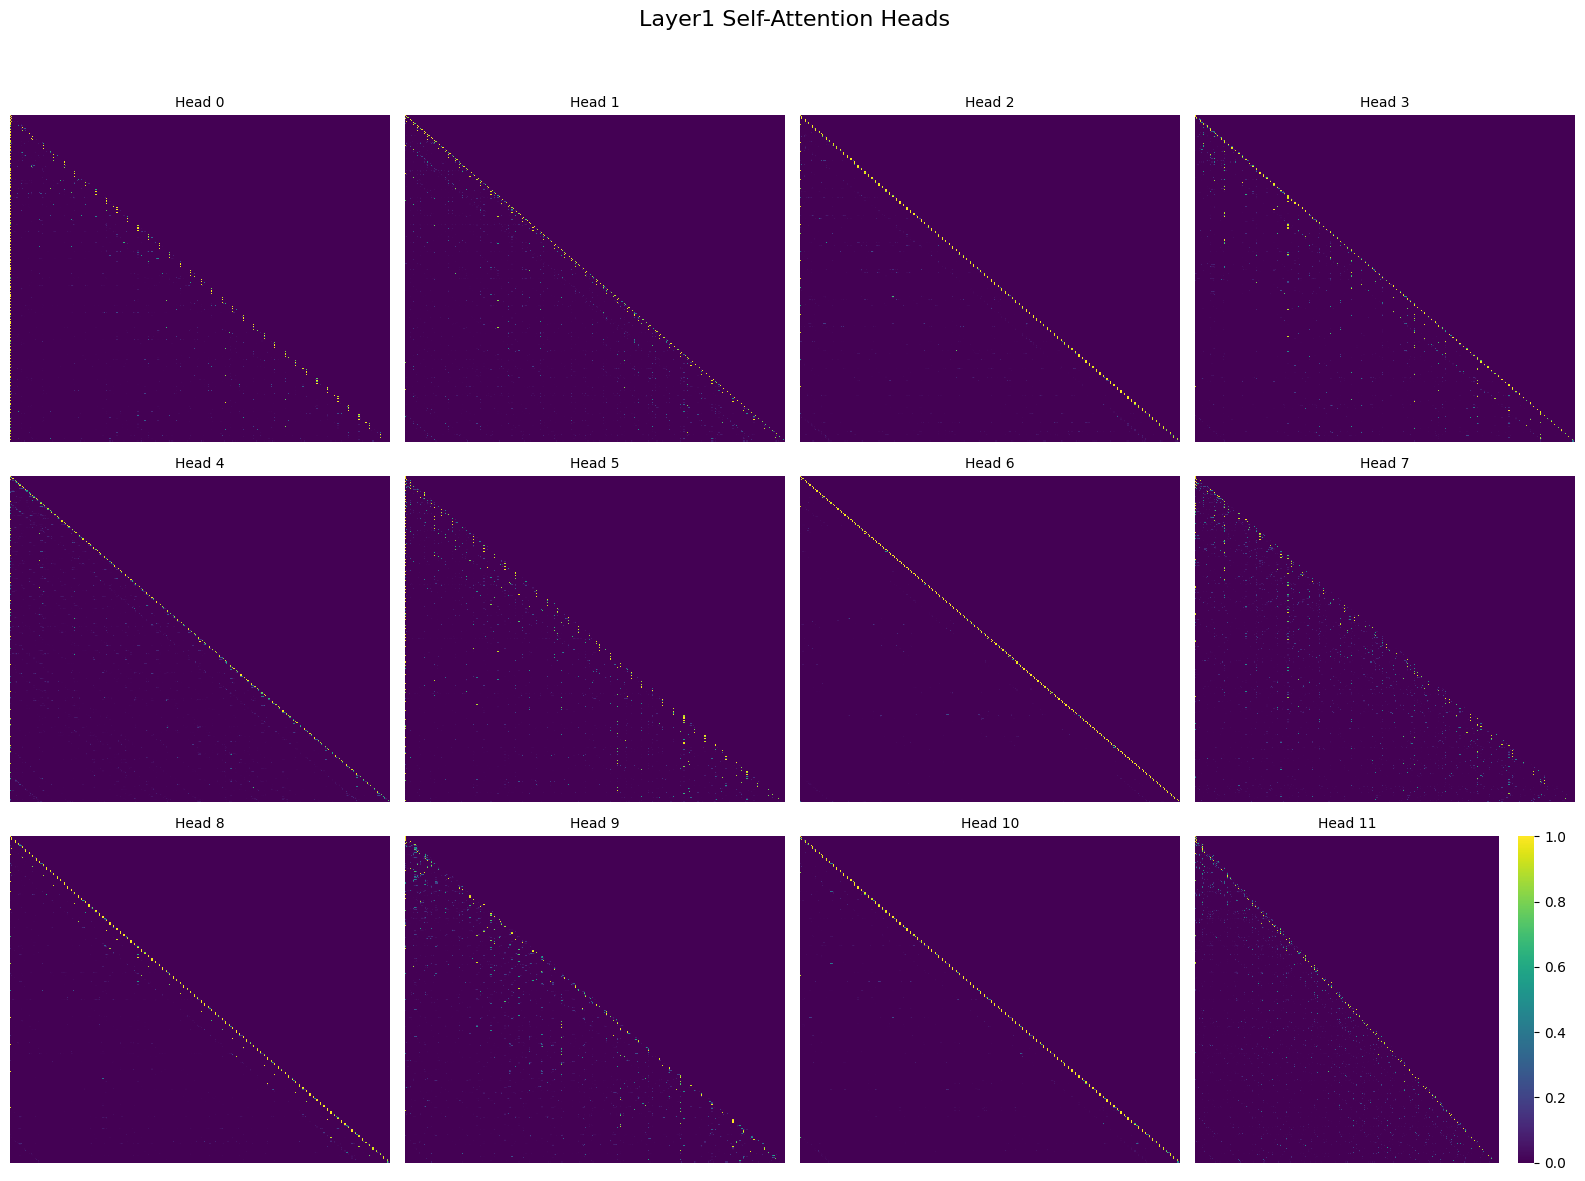

In [39]:
#attn_weights["layer1_dec_self"][0].shape
from matplotlib import pyplot as plt
import seaborn as sns
heads = attn_weights["layer1_dec_self"].cpu()
heads = heads.mean(dim = 0).numpy()

n_heads, T, _ = heads.shape
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < n_heads:
        data = heads[i]
        sns.heatmap(
            data,
            cmap="viridis", cbar=(i==n_heads-1),  # only draw one colorbar
            ax=ax,
            xticklabels=False,
            yticklabels=False
        )
        ax.set_title(f"Head {i}", fontsize=10)
    else:
        ax.axis("off")

fig.suptitle("Layer1 Self-Attention Heads", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [34]:
trainer._validate_epoch(val_loader)

generating
Using default generation config...
Generating with greedy search...


({'ce_loss_token': 0.3264254592359066, 'perplexity_token': 1.38600492477417},
 {'layer1_dec_self': tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [9.4829e-03, 9.9052e-01, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.0000e+00, 4.8788e-11, 9.5991e-15,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            ...,
            [7.3725e-12, 2.1912e-06, 2.7731e-13,  ..., 9.0761e-06,
             0.0000e+00, 0.0000e+00],
            [9.5858e-01, 1.6304e-15, 2.3588e-11,  ..., 2.8637e-14,
             2.2290e-14, 0.0000e+00],
            [2.3428e-03, 1.7952e-03, 2.5554e-04,  ..., 6.3177e-03,
             2.4928e-07, 1.7577e-05]],
  
           [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.1381e-08, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.7840e-01, 2.2022e-06, 8.216

### Attention ablation 

#### Ablating Copy Pass Heads

In [5]:
import copy
trainer.model.eval()

DecoderOnlyTransformer(
  (dec_layers): ModuleList(
    (0-11): 12 x SelfAttentionDecoderLayer(
      (self_attn): SelfAttentionLayer(
        (rotary): RotaryEmbedding()
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForwardLayer(
        (ffn): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (target_embedding): Embedding(5, 768)
  (final_linear): Linear(in_features=768, out_features=5, bias=True)
  (dropout): Dropout

In [ ]:
#del trainer1
gc.collect()
trainer1 = copy.deepcopy(trainer)
W = trainer1.model.dec_layers[0].self_attn.mha.out_proj.weight
num_heads = config["model"]["num_heads"]
d_model = config["model"]["d_model"]
head_dim   = d_model // num_heads    # e.g. 64

# 3) Choose which heads to disable
heads_to_disable = [0,2,3,4,5,6,7,9,10,11]          # example: disable heads 0, 3, and 5

# 4) Zero out their weight blocks in‐place
with torch.no_grad():
    for h in heads_to_disable:
        start = h * head_dim
        end   = (h + 1) * head_dim
        W[:, start:end].zero_()

# (Optional) verify
print("Disabled heads:", heads_to_disable)
#print("Block for head 0 after zeroing:", W[:, 0:head_dim])

Disabled heads: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11]


In [8]:
trainer1._validate_epoch(val_loader)
#perplexity is 1.3962 with 2,6,10 inactive
#perplexity is 1.3958 with 7,5,9 inactive
#perplexity is 1.3958 with 0 inactive
#perplexity is 1.40 with 0,5 inactive
#perplexity is 6.13 with only 11 active
#perplexity is 6.93 with only 0 active
#perlexity is 3.5 with only 1 active
#perlexity is 3 with only 2 active
#perlexity is 3.78 with only 3 active
#perlexit is 3.73 with only 4 active
#perplexity is 3.8 with only 5 active
#perplexity is 2.8 with only 6 active
#perplexity is 3.65 with only 7 active





[Validating LM]: 0it [00:00, ?it/s]

KeyboardInterrupt: 